# Scalability final test


Extended the baseline **TD-EVRPTW BCP** implementation with a small scalability study across three instance sizes:
**C15**, **C20** (+5 customers), and **C25** (+10 customers).

**Data & augmentation**
- Starting from `r209C15_td.json`, I generated `r209C10_td.json` and `r209C20_td.json` by adding customers with small coordinate jitter and time-window shifts.
- All time-dependent components are preserved: **speed profiles** (congestion levels), **piecewise-linear charging** modes, and **time-dependent waiting** at stations.
- The `arc_speed_profiles` matrix was expanded consistently, defaulting to the **"normal"** profile for arcs involving new customers.

**Outputs**
- Plots saved under `results/scalability/`.
- `scalability_results.csv` with columns:
  `instance_name | cost | n.routes_found | feasible | n.nodes_explored`.

**Reproducibility**
- Same random seeds were used for augmentation; solver runs used `num_processes=1` for stable wall-time comparisons.


In [1]:
# Libraries Import
import os, sys, json, math, traceback
import numpy as np
import matplotlib.pyplot as plt
import csv

# BCP 
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)

from bcp_solver import BCPSolver
from utils import load_instance, PiecewiseLinearFunction, get_travel_time_and_consumption  

# test_utilities
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
utils_path = os.path.join(project_root, 'utils')

if utils_path not in sys.path:
    sys.path.insert(0, utils_path)

from test_utilities import simple_external_feasibility_check, plot_instance_and_routes

save_path = os.path.join(project_root, 'results', 'scalability')


In [2]:
# Load instance from json

INSTANCE_PATH_10 = os.path.join(project_root, "data", "TDEVRPTW", "scalability", "r209C10_td.json") 
INSTANCE_PATH_15 = os.path.join(project_root, "data", "TDEVRPTW", "scalability", "r209C15_td.json") 
INSTANCE_PATH_20 = os.path.join(project_root, "data", "TDEVRPTW", "scalability", "r209C20_td.json") 



In [3]:
# Call the solver
instance_paths = [INSTANCE_PATH_10, INSTANCE_PATH_15, INSTANCE_PATH_20]
csv_path = os.path.join(save_path, "scalability_results.csv")


rows = []  # righe CSV: [instance_name, cost, n.routes_found, feasible, n.nodes_explored]

for p in instance_paths:
    if not os.path.exists(p):
        print(f"[WARN] Instance not found: {p}")
        rows.append([os.path.basename(p), None, None, None, None])
        continue

    try:
        print(f"\n=== Solving {os.path.basename(p)} ===")
        solver = BCPSolver(p, num_processes=8)
        result = solver.solve()
    except Exception as e:
        print(f"[ERROR] Solver failed on {p}: {e}")
        traceback.print_exc()
        rows.append([os.path.basename(p), None, None, None, None])
        continue

    inst = load_instance(p)
    inst_name = inst.get("name", os.path.basename(p))
    best_cost = result.get("best_cost", None)
    best_solution = result.get("best_solution", None)
    feas_report = result.get("feasibility_report", None)
    nodes_explored = result.get("nodes_explored", None)

    n_routes_found = len(best_solution) if best_solution else 0
    feasible_flag = feas_report["feasible"] if feas_report else None

    print(f"  -> cost={best_cost}, routes={n_routes_found}, feasible={feasible_flag}, nodes={nodes_explored}")

    rows.append([inst_name, best_cost, n_routes_found, feasible_flag, nodes_explored])

# Scrivi CSV
with open(csv_path, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["instance_name", "cost", "n.routes_found", "feasible", "n.nodes_explored"])
    w.writerows(rows)

print(f"\nSaved CSV: {csv_path}")


=== Solving r209C10_td.json ===
--- Initializing Parallel BCP Solver ---
Using 8 processes for pricing.

--- Exploring B&B Node #1 ---
  Constraints: {}
Set parameter Username
Set parameter LicenseID to value 2663559
Academic license - for non-commercial use only - expires 2026-05-11
[RMP] Obj=10000000.000000 | cols=10
Running pricing heuristics in parallel...
Added 10 new columns from heuristics.
[RMP] Obj=5000106.034753 | cols=20
Running pricing heuristics in parallel...
Added 10 new columns from heuristics.
[RMP] Obj=5000106.034753 | cols=30
Running pricing heuristics in parallel...
Added 10 new columns from heuristics.
[RMP] Obj=5000106.034753 | cols=40
Running pricing heuristics in parallel...
Added 10 new columns from heuristics.
[RMP] Obj=3500158.559392 | cols=50
Running pricing heuristics in parallel...
Added 10 new columns from heuristics.
[RMP] Obj=1500215.621954 | cols=60
Running pricing heuristics in parallel...
Added 10 new columns from heuristics.
[RMP] Obj=1000216.65088

KeyboardInterrupt: 

In [9]:
# external check
ext_check = simple_external_feasibility_check(inst, best_solution or [], verbose=True)
print("External feasible:", ext_check["feasible"])
if not ext_check["feasible"]:
    for r in ext_check["reasons"]:
        print(" -", r)

# route table
if best_solution:
    print("\nRoutes (path, value, cost):")
    for i, it in enumerate(best_solution, 1):
        print(f"  #{i:02d}: path={it['route']['path']}, value={it['value']:.3f}, cost={it['route']['cost']:.3f}")

External feasible: True

Routes (path, value, cost):
  #01: path=[0, 7, 22, 5, 16, 0], value=1.000, cost=82.647
  #02: path=[0, 15, 5, 17, 20, 3, 18, 0], value=1.000, cost=168.981
  #03: path=[0, 24, 4, 25, 10, 21, 23, 3, 12, 0], value=1.000, cost=159.840
  #04: path=[0, 13, 14, 11, 0], value=1.000, cost=51.711
  #05: path=[0, 9, 6, 4, 19, 8, 1, 0], value=1.000, cost=122.731


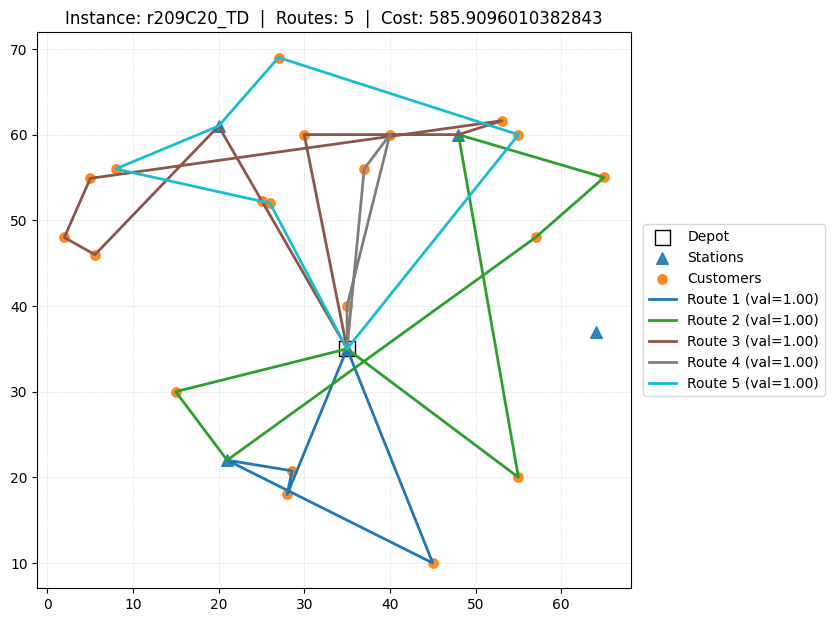

In [7]:
plot_instance_and_routes(inst, best_solution, best_cost, save_path)